<a href="https://colab.research.google.com/github/SourLemon23/brain-tumor-diagnosis/blob/master/brain_tumor_diagnosis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.applications.resnet import ResNet50, preprocess_input
import matplotlib.pyplot as plt

In [ ]:
# Initialize dataset directories (Google Drive)
training_dir   = r'/content/drive/My Drive/Colab Notebooks/Brain Tumor Diagnosis/brain_tumor_image_set/training'
validation_dir = r'/content/drive/My Drive/Colab Notebooks/Brain Tumor Diagnosis/brain_tumor_image_set/validation'
testing_dir    = r'/content/drive/My Drive/Colab Notebooks/Brain Tumor Diagnosis/brain_tumor_image_set/testing'

In [ ]:
# Store all testing images in a list
testing_img_paths = []

for root, dirs, files in os.walk(testing_dir):
    for filename in files:
        testing_img_paths.append(os.path.abspath(os.path.join(root, filename)))

# Randomize the list
random.shuffle(testing_img_paths)

# Choose a random, unseen image as the testing image
# testing_image = random.choice(testing_img_paths)
# print(testing_image)

In [ ]:
# Initialize constants
classes = ['glioma', 'meningioma', 'pituitary']
img_width, img_height = 150, 150
target_size = (img_width, img_height)
input_shape = (img_width, img_height, 3)

batch_size = 20
epochs = 3

In [ ]:
# Augment data
training_data_gen = ImageDataGenerator(rescale=1./255,
                                       shear_range=0.2,
                                       zoom_range=0.2,
                                       horizontal_flip=True)

validation_data_gen = ImageDataGenerator(rescale=1./255)

In [ ]:
# Split data
training_generator = training_data_gen.flow_from_directory(training_dir,
                                                           target_size=target_size,
                                                           class_mode='categorical',
                                                           batch_size=batch_size,
                                                           shuffle=True)

validation_generator = validation_data_gen.flow_from_directory(validation_dir,
                                                               target_size=target_size,
                                                               class_mode='categorical',
                                                               batch_size=batch_size,
                                                               shuffle=False)

Found 2460 images belonging to 3 classes.
Found 105 images belonging to 3 classes.


In [ ]:
# Create a neural network
def create_model():
    model = Sequential()

    model.add(ResNet50(include_top=False, weights='imagenet', input_shape = input_shape))
    model.add(Dropout(0.5))

    model.add(Conv2D(16, (3, 3), activation = 'relu', padding='same', input_shape = input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(BatchNormalization())

    model.add(Conv2D(32, (3, 3), activation = 'relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(BatchNormalization())

    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(training_generator.num_classes, activation='softmax'))

    return model

In [ ]:
# Print an overall summary of the model
def print_model_summary(model):
    model.summary()

In [ ]:
# Configure model
def compile_model(model):
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

In [ ]:
# Train the model
def fit_model(model):
    history = model.fit(training_generator,
                        epochs=epochs,
                        steps_per_epoch=(training_generator.n/batch_size),
                        validation_data=validation_generator,
                        validation_steps=(validation_generator.n/batch_size))
    
    return history

In [ ]:
# Plot and evaluate the model
def evaluate_model(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.show()

In [ ]:
# # Classify a tumor from an MRI scan
# def classify_tumor(model, testing_img_paths):
#     for i, img_path in enumerate(testing_img_paths):
#         img = load_img(
#             img_path,
#             target_size=target_size)

#         img_array = img_to_array(img)
#         img_array = preprocess_input(img_array)
#         img_array = img_array.reshape((-1, 150, 150, 3))

#         predictions = model.predict(img_array)
#         class_num = predictions.argmax()

#         network_percent_confidence = str(np.max(predictions) * 100)[:4] + '%'
#         network_prediction = classes[class_num].capitalize()

#         font = {'family': 'DejaVu Sans',
#                 'color' : 'red',
#                 'weight': 'heavy',
#                 'size'  :  10}

#         print(f'MRI Scan #{i+1})')

#         print(testing_img_paths[i])
        
#         plt.imshow(img)
#         plt.title(f'Network Prediction: {network_prediction} ({network_percent_confidence})', fontdict=font)
#         plt.show()

In [ ]:
model = create_model()
compile_model(model)
print_model_summary(model)

# history = fit_model(model)
# evaluate_model(history)

# classify_tumor(model, testing_img_paths)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 5, 5, 2048)        23587712  
_________________________________________________________________
dropout_6 (Dropout)          (None, 5, 5, 2048)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 5, 5, 16)          294928    
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 3, 3, 16)          0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 3, 3, 16)          64        
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 3, 3, 32)          4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 2, 2, 32)         

Epoch 1/3
123/123 [==============================] - 26s 215ms/step - loss: 0.5739 - accuracy: 0.7707 - val_loss: 1.1602 - val_accuracy: 0.3333
Epoch 2/3
123/123 [==============================] - 25s 207ms/step - loss: 0.3574 - accuracy: 0.8614 - val_loss: 2.7597 - val_accuracy: 0.3333
Epoch 3/3
123/123 [==============================] - 26s 209ms/step - loss: 0.2719 - accuracy: 0.9004 - val_loss: 1.3890 - val_accuracy: 0.3333


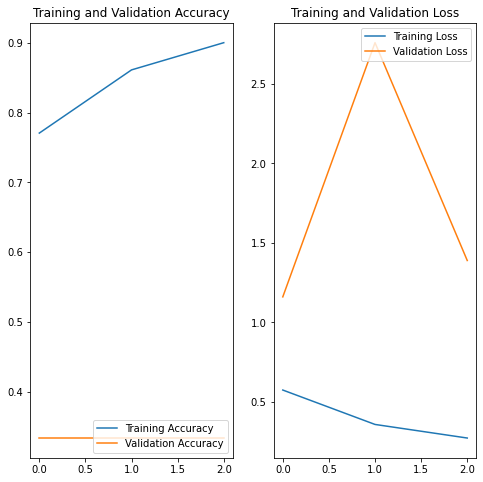

In [ ]:
history = fit_model(model)
evaluate_model(history)

In [ ]:
# Classify a tumor from an MRI scan
def classify_tumor(model, testing_img_paths):
    for i, img_path in enumerate(testing_img_paths):
        img = load_img(
            img_path,
            target_size=target_size)

        img_array = img_to_array(img)
        img_array = preprocess_input(img_array)
        img_array = img_array.reshape((-1, 150, 150, 3))

        predictions = model.predict(img_array)
        class_num = predictions.argmax()

        print(class_num)

        print(predictions)

        network_percent_confidence = str(np.max(predictions) * 100)[:4] + '%'
        network_prediction = ['glioma', 'meningioma', 'pituitary'][class_num].capitalize()
        # network_prediction = classes[class_num].capitalize()

        font = {'family': 'DejaVu Sans',
                'color' : 'red',
                'weight': 'heavy',
                'size'  :  10}

        print(f'MRI Scan #{i+1})')

        print(testing_img_paths[i])
        
        plt.imshow(img)
        plt.title(f'Network Prediction: {network_prediction} ({network_percent_confidence})', fontdict=font)
        plt.show()

1
[[0.02482251 0.9545114  0.020666  ]]
MRI Scan #1)
/content/drive/My Drive/Colab Notebooks/Brain Tumor Diagnosis/brain_tumor_image_set/testing/meningioma/image(107).jpg


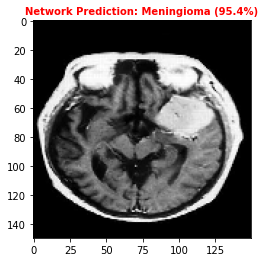

1
[[0.02555154 0.9471869  0.02726159]]
MRI Scan #2)
/content/drive/My Drive/Colab Notebooks/Brain Tumor Diagnosis/brain_tumor_image_set/testing/glioma/image(51).jpg


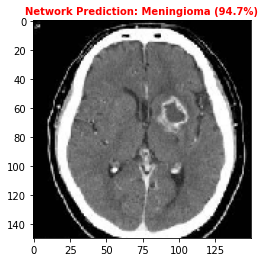

1
[[0.07355617 0.85417116 0.07227272]]
MRI Scan #3)
/content/drive/My Drive/Colab Notebooks/Brain Tumor Diagnosis/brain_tumor_image_set/testing/glioma/image(87).jpg


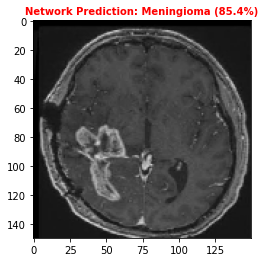

1
[[0.04603191 0.9045271  0.04944099]]
MRI Scan #4)
/content/drive/My Drive/Colab Notebooks/Brain Tumor Diagnosis/brain_tumor_image_set/testing/glioma/image(81).jpg


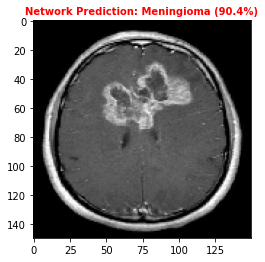

1
[[0.05789663 0.893189   0.04891429]]
MRI Scan #5)
/content/drive/My Drive/Colab Notebooks/Brain Tumor Diagnosis/brain_tumor_image_set/testing/glioma/image(60).jpg


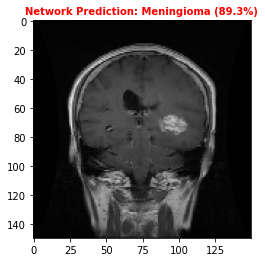

1
[[0.08129802 0.8510182  0.0676838 ]]
MRI Scan #6)
/content/drive/My Drive/Colab Notebooks/Brain Tumor Diagnosis/brain_tumor_image_set/testing/pituitary/image(92).jpg


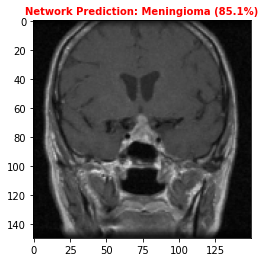

1
[[0.02803269 0.95307165 0.01889565]]
MRI Scan #7)
/content/drive/My Drive/Colab Notebooks/Brain Tumor Diagnosis/brain_tumor_image_set/testing/glioma/image(92).jpg


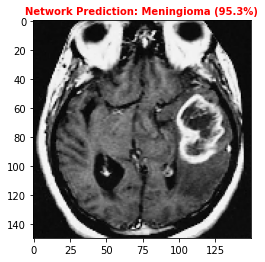

1
[[0.03961484 0.91303194 0.04735318]]
MRI Scan #8)
/content/drive/My Drive/Colab Notebooks/Brain Tumor Diagnosis/brain_tumor_image_set/testing/meningioma/image(99).jpg


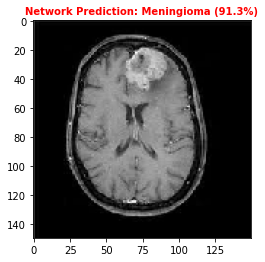

1
[[0.06003459 0.8861985  0.0537669 ]]
MRI Scan #9)
/content/drive/My Drive/Colab Notebooks/Brain Tumor Diagnosis/brain_tumor_image_set/testing/glioma/image(64).jpg


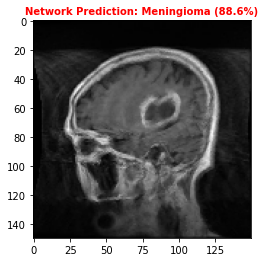

1
[[0.02539997 0.9504346  0.02416547]]
MRI Scan #10)
/content/drive/My Drive/Colab Notebooks/Brain Tumor Diagnosis/brain_tumor_image_set/testing/glioma/image(91).jpg


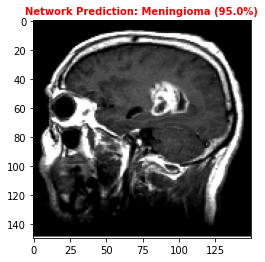

1
[[0.03616646 0.919392   0.04444155]]
MRI Scan #11)
/content/drive/My Drive/Colab Notebooks/Brain Tumor Diagnosis/brain_tumor_image_set/testing/glioma/image(95).jpg


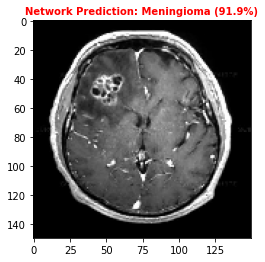

1
[[0.05143044 0.89166987 0.05689968]]
MRI Scan #12)
/content/drive/My Drive/Colab Notebooks/Brain Tumor Diagnosis/brain_tumor_image_set/testing/pituitary/image(61).jpg


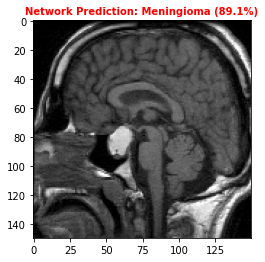

1
[[0.04331173 0.90944874 0.04723959]]
MRI Scan #13)
/content/drive/My Drive/Colab Notebooks/Brain Tumor Diagnosis/brain_tumor_image_set/testing/glioma/image(88).jpg


Exception ignored in: <function TransformNode.set_children.<locals>.<lambda> at 0x7f7be8fb37b8>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/matplotlib/transforms.py", line 177, in <lambda>
    ref = weakref.ref(self, lambda ref, sid=id(self),
KeyboardInterrupt


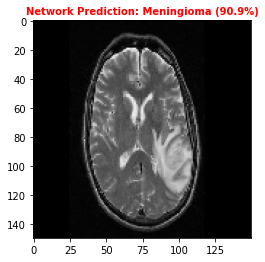

1
[[0.04653236 0.8948298  0.05863785]]
MRI Scan #14)
/content/drive/My Drive/Colab Notebooks/Brain Tumor Diagnosis/brain_tumor_image_set/testing/glioma/image(78).jpg


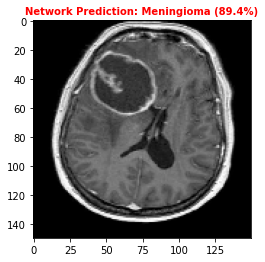

1
[[0.04321144 0.9198682  0.03692032]]
MRI Scan #15)
/content/drive/My Drive/Colab Notebooks/Brain Tumor Diagnosis/brain_tumor_image_set/testing/meningioma/image(95).jpg


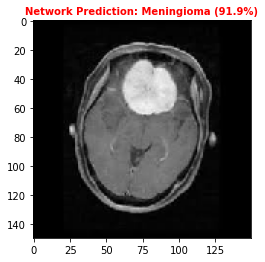

1
[[0.05871906 0.87822855 0.06305239]]
MRI Scan #16)
/content/drive/My Drive/Colab Notebooks/Brain Tumor Diagnosis/brain_tumor_image_set/testing/pituitary/image(94).jpg


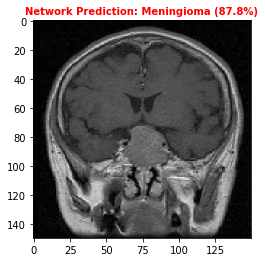

1
[[0.05134838 0.8894399  0.05921176]]
MRI Scan #17)
/content/drive/My Drive/Colab Notebooks/Brain Tumor Diagnosis/brain_tumor_image_set/testing/pituitary/image(69).jpg


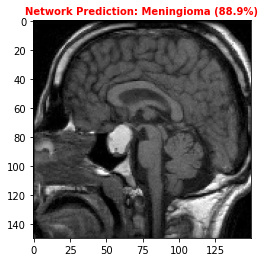

1
[[0.03813509 0.9260073  0.03585762]]
MRI Scan #18)
/content/drive/My Drive/Colab Notebooks/Brain Tumor Diagnosis/brain_tumor_image_set/testing/glioma/image(94).jpg


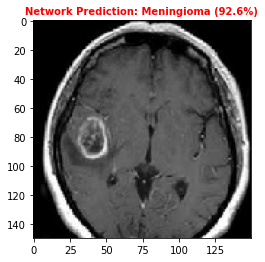

1
[[0.02808813 0.9318133  0.04009861]]
MRI Scan #19)
/content/drive/My Drive/Colab Notebooks/Brain Tumor Diagnosis/brain_tumor_image_set/testing/meningioma/image(126).jpg


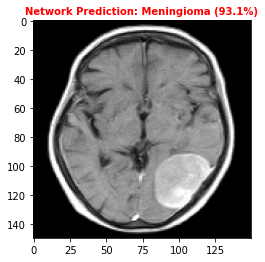

1
[[0.06185161 0.88001776 0.05813067]]
MRI Scan #20)
/content/drive/My Drive/Colab Notebooks/Brain Tumor Diagnosis/brain_tumor_image_set/testing/pituitary/image(76).jpg


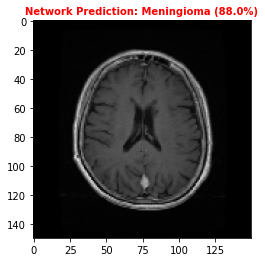

KeyboardInterrupt: ignored

In [ ]:
classify_tumor(model, testing_img_paths)